In [1]:
import os
import glob
import pandas as pd
import pickle
import matplotlib.pyplot as plt
import numpy as np
import random
from datetime import datetime, timedelta
from dateutil.relativedelta import relativedelta
import pprint
import pyspark
import pyspark.sql.functions as F

from pyspark.sql.functions import col
from pyspark.sql.types import StringType, IntegerType, FloatType, DateType

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

import xgboost as xgb
from sklearn.model_selection import RandomizedSearchCV
from sklearn.metrics import make_scorer, f1_score, roc_auc_score
from sklearn.datasets import make_classification
from sklearn.model_selection import train_test_split


In [2]:
# Build a .py script that takes a snapshot date, trains a model and outputs artefact into storage.

## set up pyspark session

In [4]:
# Initialize SparkSession
spark = pyspark.sql.SparkSession.builder \
    .appName("dev") \
    .master("local[*]") \
    .getOrCreate()

# Set log level to ERROR to hide warnings
spark.sparkContext.setLogLevel("ERROR")

## set up config

In [5]:
# set up config
model_train_date_str = "2024-01-01"
train_test_period_months = 12
oot_period_months = 2
train_test_ratio = 0.8

config = {}
config["model_train_date_str"] = model_train_date_str
config["train_test_period_months"] = train_test_period_months
config["oot_period_months"] =  oot_period_months
config["model_train_date"] =  datetime.strptime(model_train_date_str, "%Y-%m-%d")
config["oot_end_date"] =  config['model_train_date'] - timedelta(days = 1)
config["oot_start_date"] =  config['model_train_date'] - relativedelta(months = oot_period_months)
config["train_test_end_date"] =  config["oot_start_date"] - timedelta(days = 1)
config["train_test_start_date"] =  config["oot_start_date"] - relativedelta(months = train_test_period_months)
config["train_test_ratio"] = train_test_ratio 


pprint.pprint(config)

{'model_train_date': datetime.datetime(2024, 1, 1, 0, 0),
 'model_train_date_str': '2024-01-01',
 'oot_end_date': datetime.datetime(2023, 12, 31, 0, 0),
 'oot_period_months': 2,
 'oot_start_date': datetime.datetime(2023, 11, 1, 0, 0),
 'train_test_end_date': datetime.datetime(2023, 10, 31, 0, 0),
 'train_test_period_months': 12,
 'train_test_ratio': 0.8,
 'train_test_start_date': datetime.datetime(2022, 11, 1, 0, 0)}


## get label store

In [101]:
# connect to label store
folder_path = "datamart/gold/label_store/"
files_list = [folder_path+os.path.basename(f) for f in glob.glob(os.path.join(folder_path, '*'))]
label_store_sdf = spark.read.option("header", "true").parquet(*files_list)
print("row_count:",label_store_sdf.count())

label_store_sdf.show()

row_count: 12500
+--------------------+-----------+-----+----------+-------------+
|             loan_id|Customer_ID|label| label_def|snapshot_date|
+--------------------+-----------+-----+----------+-------------+
|CUS_0x10ac_2024_0...| CUS_0x10ac|    0|30dpd_6mob|   2025-02-01|
|CUS_0x10c5_2024_0...| CUS_0x10c5|    1|30dpd_6mob|   2025-02-01|
|CUS_0x1145_2024_0...| CUS_0x1145|    1|30dpd_6mob|   2025-02-01|
|CUS_0x11ac_2024_0...| CUS_0x11ac|    0|30dpd_6mob|   2025-02-01|
|CUS_0x122c_2024_0...| CUS_0x122c|    0|30dpd_6mob|   2025-02-01|
|CUS_0x1274_2024_0...| CUS_0x1274|    1|30dpd_6mob|   2025-02-01|
|CUS_0x1288_2024_0...| CUS_0x1288|    1|30dpd_6mob|   2025-02-01|
|CUS_0x12cc_2024_0...| CUS_0x12cc|    1|30dpd_6mob|   2025-02-01|
|CUS_0x1338_2024_0...| CUS_0x1338|    0|30dpd_6mob|   2025-02-01|
|CUS_0x1370_2024_0...| CUS_0x1370|    1|30dpd_6mob|   2025-02-01|
|CUS_0x1378_2024_0...| CUS_0x1378|    1|30dpd_6mob|   2025-02-01|
|CUS_0x139b_2024_0...| CUS_0x139b|    0|30dpd_6mob|   2025-

In [102]:
# extract label store
labels_sdf = label_store_sdf.filter((col("snapshot_date") >= config["train_test_start_date"]) & (col("snapshot_date") <= config["oot_end_date"]))

print("extracted labels_sdf", labels_sdf.count(), config["train_test_start_date"], config["oot_end_date"])

extracted labels_sdf 3085 2022-11-01 00:00:00 2023-12-31 00:00:00


## get features

In [98]:
folder_path = "datamart/silver/feature_store/"
feature_store = [folder_path+os.path.basename(f) for f in glob.glob(os.path.join(folder_path, '*'))]
features_store_sdf = spark.read.option("header", "true").parquet(*feature_store)
# Load CSV into DataFrame - connect to feature store
print("row_count:",features_store_sdf.count())

features_store_sdf.show()

row_count: 215304
+-----------+-------------+-----------------+---------------+-------------+-----------+-------------------+----------------------+--------------------+--------------------+----------+----------------+------------------------+---------------------+-------------------+-----------------------+---------------+-------------------------+-----------------+--------------------------+---------------------+-----------------------+---------------------------------+-----------------------+----------------------+-----------------------------+-------------------+-----------------------+--------------+------------+-------+--------------------+------------------------+-------------------+-----------------+------------------+--------------------+-----------------+--------------------+-------------------+-----------------------+-----------------+---------------------+-----------------+-------------------+---------------------+------------------+----+----+----+----+----+----+----+----+-

In [99]:
# extract label store
features_sdf = features_store_sdf.filter((col("snapshot_date") >= config["train_test_start_date"]) & (col("snapshot_date") <= config["oot_end_date"]))

print("extracted features_sdf", features_sdf.count(), config["train_test_start_date"], config["oot_end_date"])

extracted features_sdf 107652 2022-11-01 00:00:00 2023-12-31 00:00:00


In [103]:
features_sdf.count(), labels_sdf.count()

(107652, 3085)

## prepare data for modeling

In [104]:
# prepare data for modeling, left join labels to features. 
# preprocessing depends on the model we are using. need to understand the preprocessing req for the models.
data_pdf = labels_sdf.join(features_sdf, on=["Customer_ID", "snapshot_date"], how="left").toPandas()
data_pdf

,Customer_ID,snapshot_date,loan_id,label,label_def,Annual_Income,Num_Bank_Accounts,Num_Credit_Card,Interest_Rate,Num_of_Loan,...,fe_12,fe_13,fe_14,fe_15,fe_16,fe_17,fe_18,fe_19,fe_20,snapshot_age
0,CUS_0x10eb,2023-09-01,CUS_0x10eb_2023_03_01,0,30dpd_6mob,28315.95,4,7,10.0,2,...,124,166,175,-164,277,-18,239,45,-37,51
1,CUS_0x1192,2023-11-01,CUS_0x1192_2023_05_01,0,30dpd_6mob,16319.38,7,3,1.0,2,...,202,-64,-53,71,95,122,-3,123,61,-1
2,CUS_0x1431,2023-10-01,CUS_0x1431_2023_04_01,1,30dpd_6mob,110525.97,7,7,9.0,5,...,-14,155,-20,183,7,86,-7,53,135,32
3,CUS_0x1690,2023-09-01,CUS_0x1690_2023_03_01,1,30dpd_6mob,51266.34,6,6,24.0,7,...,109,209,0,101,72,20,158,-52,239,44
4,CUS_0x1766,2023-12-01,CUS_0x1766_2023_06_01,1,30dpd_6mob,17849.00,6,6,15.0,7,...,144,110,88,363,171,93,288,91,53,14
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3080,CUS_0xc5f3,2023-10-01,CUS_0xc5f3_2023_04_01,0,30dpd_6mob,15728.24,7,6,31.0,2,...,110,197,188,3,271,-52,102,108,46,19
3081,CUS_0xc8c,2023-10-01,CUS_0xc8c_2023_04_01,0,30dpd_6mob,14822.00,7,7,14.0,3,...,116,216,201,261,265,-35,-61,-2,219,23
3082,CUS_0xd6f,2023-07-01,CUS_0xd6f_2023_01_01,0,30dpd_6mob,70045.84,4,6,6.0,2,...,-17,187,-66,207,46,76,-94,41,-8,40
3083,CUS_0xf45,2023-11-01,CUS_0xf45_2023_05_01,1,30dpd_6mob,32057.30,9,8,16.0,7,...,172,238,61,108,26,88,22,136,82,28


In [105]:
dist_pct = data_pdf["label"].value_counts(normalize=True)
print("Distribution of labels in the dataset:",dist_pct*100,"%")

Distribution of labels in the dataset: label
0    71.831442
1    28.168558
Name: proportion, dtype: float64 %


In [97]:
# split data into train - test - oot
# do quick sanity check of the number of samples in each set.
oot_pdf = data_pdf[(data_pdf['snapshot_date'] >= config["oot_start_date"].date()) & (data_pdf['snapshot_date'] <= config["oot_end_date"].date())]
train_test_pdf = data_pdf[(data_pdf['snapshot_date'] >= config["train_test_start_date"].date()) & (data_pdf['snapshot_date'] <= config["train_test_end_date"].date())]

feature_cols = [fe_col for fe_col in data_pdf.columns if fe_col not in ["Customer_ID", "snapshot_date", "label","loan_id", "label_def"]]


X_oot = oot_pdf[feature_cols]
y_oot = oot_pdf["label"]
X_train, X_test, y_train, y_test = train_test_split(
    train_test_pdf[feature_cols], train_test_pdf["label"], 
    test_size= 1 - config["train_test_ratio"],
    random_state=88,     # Ensures reproducibility
    shuffle=True,        # Shuffle the data before splitting. If col seqeunce are impt, dont shuffle.
    stratify=train_test_pdf["label"]           # Stratify based on the label column. 
)

print('X_train', X_train.shape[0])
print('X_test', X_test.shape[0])
print('X_oot', X_oot.shape[0])
print('y_train', y_train.shape[0], round(y_train.mean(),2)) # calculates the bad rate. 
# if bad rate is different across, dont build a model. EDA to figure out why. dont proceed until value makes sense.
print('y_test', y_test.shape[0], round(y_test.mean(),2))
print('y_oot', y_oot.shape[0], round(y_oot.mean(),2))

X_train

X_train 1637
X_test 410
X_oot 1038
y_train 1637 0.29
y_test 410 0.29
y_oot 1038 0.27


,Num_Bank_Accounts,Num_Credit_Card,Interest_Rate,Changed_Credit_Limit,Num_Credit_Inquiries,Credit_Mix,Outstanding_Debt,Credit_Utilization_Ratio,Monthly_Balance,Credit_History_Age_Months,...,fe_12,fe_13,fe_14,fe_15,fe_16,fe_17,fe_18,fe_19,fe_20,snapshot_age
2072,7,3,14.0,4.29,3,0,1011.38,27.89,784.96,386.0,...,59,273,1,191,236,18,202,149,97,50
2990,2,5,9.0,5.42,4,3,1435.21,31.06,281.98,370.0,...,108,-92,-42,305,139,187,-21,-47,128,34
1114,6,6,10.0,7.07,4,3,583.79,34.40,213.83,277.0,...,228,102,136,77,70,136,53,-73,170,55
198,7,7,16.0,9.09,10,1,1300.71,26.98,281.21,177.0,...,14,-38,168,271,111,129,214,-47,171,45
3058,3,4,5.0,3.70,1,0,162.87,31.10,304.91,308.0,...,-116,178,-17,-29,267,77,15,236,50,48
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1737,8,4,14.0,16.11,12,0,2519.19,24.14,625.10,123.0,...,65,69,59,76,164,-7,121,255,94,43
881,3,5,5.0,14.47,4,3,583.40,33.20,177.41,225.0,...,221,120,96,54,223,163,138,-77,-6,53
2461,7,7,26.0,8.19,10,0,1432.13,31.82,102.85,95.0,...,-128,324,183,84,69,54,-65,-2,54,29
1850,9,8,26.0,11.26,14,0,1369.54,26.32,345.89,97.0,...,-36,213,122,73,266,164,-106,-50,71,35


## preprocess data

In [88]:
# set up standard scalar preprocessing
scaler = StandardScaler()

transformer_stdscaler = scaler.fit(X_train) # Q which should we use? train? test? oot? all?

# transform data
X_train_processed = transformer_stdscaler.transform(X_train)
X_test_processed = transformer_stdscaler.transform(X_test)
X_oot_processed = transformer_stdscaler.transform(X_oot)

print('X_train_processed', X_train_processed.shape[0])
print('X_test_processed', X_test_processed.shape[0])
print('X_oot_processed', X_oot_processed.shape[0])

pd.DataFrame(X_train_processed) # print out to see if fit correctly

X_train_processed 2326
X_test_processed 410
X_oot_processed 1038


,0,1,2,3,4,5,6,7,8,9,...,33,34,35,36,37,38,39,40,41,42
0,0.518740,-1.345514,-0.231180,-0.943854,-1.073588,-0.695533,-0.481454,-0.876719,2.067219,1.784694,...,-0.443364,1.760449,-1.041952,0.901902,1.392832,-0.895585,0.984688,0.489265,0.030915,-0.083032
1,-1.446388,-0.360103,-0.783944,-0.767717,-0.808721,1.915241,-0.131054,-0.223086,-0.510378,1.618908,...,0.074844,-1.913610,-1.483322,2.061830,0.379003,0.888776,-1.260915,-1.528975,0.347017,-0.105585
2,0.125714,0.132603,-0.673391,-0.510526,-0.808721,1.915241,-0.834963,0.465600,-0.859623,0.655279,...,1.343924,0.039177,0.343743,-0.258027,-0.342174,0.350300,-0.515737,-1.796701,0.775285,-0.075984
3,0.518740,0.625308,-0.010074,-0.195662,0.780481,0.174725,-0.242251,-1.064355,-0.514324,-0.380882,...,-0.919269,-1.370051,0.672204,1.715887,0.086351,0.276392,1.105527,-1.528975,0.785482,-0.090080
4,-1.053363,-0.852809,-1.226155,-1.035819,-1.603322,-0.695533,-1.182957,-0.214839,-0.392870,0.976489,...,-2.294106,0.804187,-1.226712,-1.336558,1.716840,-0.272642,-0.898396,1.385116,-0.448337,-0.085851
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2321,0.911765,0.625308,0.976786,1.293570,0.515614,0.174725,2.046623,0.537336,-0.892072,-1.771141,...,0.423841,0.602869,-1.462793,0.016693,-0.572115,0.139133,-0.596297,-0.458072,0.163474,-0.115453
2322,0.911765,0.132603,0.625089,-1.396320,1.310215,-0.695533,0.423929,0.683202,-0.842394,-0.031189,...,0.603627,1.156494,-0.549261,-1.621453,-0.467597,-0.103709,1.367346,0.921745,0.092096,-0.095718
2323,0.125714,-1.345514,-0.464741,0.479177,-1.868189,-0.695533,-0.396806,-0.149162,0.005104,1.852322,...,-0.231851,-1.359985,-0.005247,0.444035,0.190870,-0.219851,-1.432104,0.674613,0.867057,-0.085851
2324,0.911765,-0.360103,1.648217,0.733854,1.045348,-0.695533,0.435019,0.742222,0.045643,-1.050179,...,-2.685406,-0.725832,1.390713,-0.258027,0.755270,1.902377,-0.616437,0.540751,-0.305581,-0.128139


## train model

In [ ]:
# Define the XGBoost classifier
xgb_clf = xgb.XGBClassifier(eval_metric='logloss', random_state=88)

# Define the hyperparameter space to search
param_dist = {
    'n_estimators': [25, 50],
    'max_depth': [2, 3],  # lower max_depth to simplify the model
    'learning_rate': [0.01, 0.1],
    'subsample': [0.6, 0.8],
    'colsample_bytree': [0.6, 0.8],
    'gamma': [0, 0.1],
    'min_child_weight': [1, 3, 5],
    'reg_alpha': [0, 0.1, 1],
    'reg_lambda': [1, 1.5, 2]   
}

# Create a scorer based on AUC score: Metric
auc_scorer = make_scorer(roc_auc_score)

# Set up the random search with cross-validation
random_search = RandomizedSearchCV(
    estimator=xgb_clf,
    param_distributions=param_dist,
    scoring=auc_scorer,
    n_iter=10,  # Number of iterations for random search (10)
    cv=3,       # Number of folds in cross-validation
    verbose=1,
    random_state=42,
    n_jobs=-1   # Use all available cores, speeds up processing
)

# Perform the random search
random_search.fit(X_train_processed, y_train)

# Output the best parameters and best score
print("Best parameters found: ", random_search.best_params_)
print("Best AUC score: ", random_search.best_score_)

# Evaluate the model on the train set
best_model = random_search.best_estimator_
y_pred_proba = best_model.predict_proba(X_train_processed)[:, 1]
train_auc_score = roc_auc_score(y_train, y_pred_proba)
print("Train AUC score: ", train_auc_score)

# Evaluate the model on the test set
best_model = random_search.best_estimator_
y_pred_proba = best_model.predict_proba(X_test_processed)[:, 1]
test_auc_score = roc_auc_score(y_test, y_pred_proba)
print("Test AUC score: ", test_auc_score)

# Evaluate the model on the oot set
best_model = random_search.best_estimator_
y_pred_proba = best_model.predict_proba(X_oot_processed)[:, 1]
oot_auc_score = roc_auc_score(y_oot, y_pred_proba)
print("OOT AUC score: ", oot_auc_score)

print("TRAIN GINI score: ", round(2*train_auc_score-1,3))
print("Test GINI score: ", round(2*test_auc_score-1,3))
print("OOT GINI score: ", round(2*oot_auc_score-1,3))

# gini higher the better. 
# why train gini > test gini? 
# it is not generalising well. (overfitting)

Fitting 3 folds for each of 10 candidates, totalling 30 fits
Best parameters found:  {'subsample': 0.6, 'reg_lambda': 1, 'reg_alpha': 0, 'n_estimators': 50, 'min_child_weight': 1, 'max_depth': 3, 'learning_rate': 0.1, 'gamma': 0.1, 'colsample_bytree': 0.8}
Best AUC score:  0.7639865650834242
Train AUC score:  0.9272650785283413
Test AUC score:  0.7889918854139593
OOT AUC score:  0.8036631290653885
TRAIN GINI score:  0.855
Test GINI score:  0.578
OOT GINI score:  0.607


In [90]:
importances = best_model.feature_importances_
feature_names = X_train.columns
importance_df = pd.DataFrame({
    'feature': feature_names,
    'importance': importances
})
importance_df = importance_df.sort_values('importance', ascending=False)
print(importance_df)

                        feature  importance
6              Outstanding_Debt    0.120882
14               Spending_Level    0.044434
2                 Interest_Rate    0.042064
15                 Payment_Size    0.033101
4          Num_Credit_Inquiries    0.032918
11       medium_risk_loan_count    0.029508
5                    Credit_Mix    0.028779
19                    dti_ratio    0.028330
12          low_risk_loan_count    0.026680
1               Num_Credit_Card    0.025845
3          Changed_Credit_Limit    0.024750
23                         fe_2    0.024622
40                        fe_19    0.023975
9     Credit_History_Age_Months    0.023523
41                        fe_20    0.023428
10         high_risk_loan_count    0.022766
13       unspecified_loan_count    0.022754
20               payment_burden    0.022753
37                        fe_16    0.022750
24                         fe_3    0.021664
35                        fe_14    0.021336
42                 snapshot_age 

In [91]:
from sklearn.metrics import (
    accuracy_score, precision_score, recall_score, f1_score,
    roc_auc_score, roc_curve, precision_recall_curve,
    confusion_matrix, classification_report,
    log_loss
)
# First, generate class predictions (not probabilities)
y_pred = best_model.predict(X_test_processed)  # Returns 0/1 predictions

# Then calculate accuracy and other metrics using the class predictions
accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred)
recall = recall_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred)

# For AUC, continue using probabilities
y_pred_proba = best_model.predict_proba(X_test_processed)[:, 1]
auc = roc_auc_score(y_test, y_pred_proba)

results = {
    'Accuracy': accuracy,
    'Precision': precision,
    'Recall': recall,
    'F1 Score': f1,
    'AUC': auc
}
print(results)

{'Accuracy': 0.775609756097561, 'Precision': 0.6153846153846154, 'Recall': 0.6050420168067226, 'F1 Score': 0.6101694915254237, 'AUC': 0.7889918854139593}


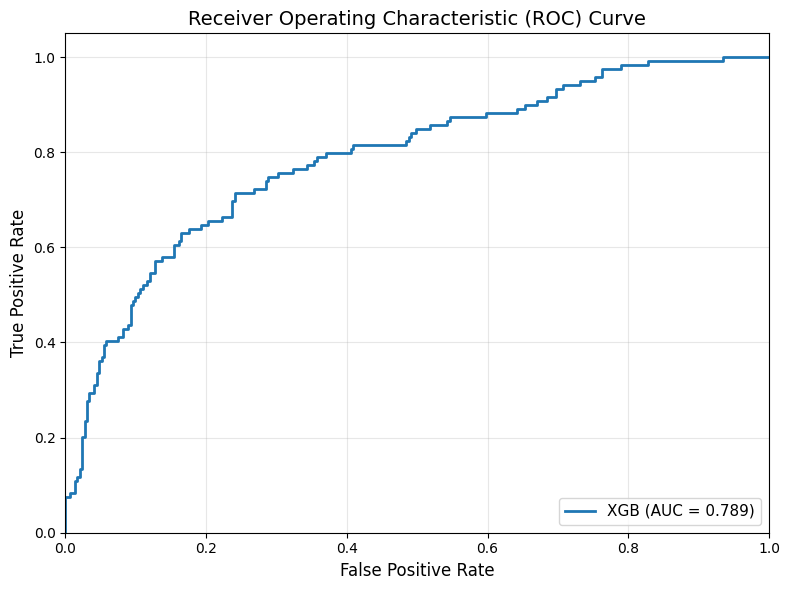

In [92]:
from sklearn.metrics import auc

fpr, tpr, thresholds = roc_curve(y_test, y_pred_proba)
roc_auc = auc(fpr, tpr)

# Create plot
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, linewidth=2, label=f'XGB (AUC = {roc_auc:.3f})')



plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate', fontsize=12)
plt.ylabel('True Positive Rate', fontsize=12)
plt.title('Receiver Operating Characteristic (ROC) Curve', fontsize=14)
plt.legend(loc="lower right", fontsize=11)
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

## prepare model artefact to save

In [13]:
model_artefact = {}

model_artefact['model'] = best_model
model_artefact['model_version'] = "credit_model_"+config["model_train_date_str"].replace('-','_')
model_artefact['preprocessing_transformers'] = {}
model_artefact['preprocessing_transformers']['stdscaler'] = transformer_stdscaler
model_artefact['data_dates'] = config
model_artefact['data_stats'] = {}
model_artefact['data_stats']['X_train'] = X_train.shape[0]
model_artefact['data_stats']['X_test'] = X_test.shape[0]
model_artefact['data_stats']['X_oot'] = X_oot.shape[0]
model_artefact['data_stats']['y_train'] = round(y_train.mean(),2)
model_artefact['data_stats']['y_test'] = round(y_test.mean(),2)
model_artefact['data_stats']['y_oot'] = round(y_oot.mean(),2)
model_artefact['results'] = {}
model_artefact['results']['auc_train'] = train_auc_score
model_artefact['results']['auc_test'] = test_auc_score
model_artefact['results']['auc_oot'] = oot_auc_score
model_artefact['results']['gini_train'] = round(2*train_auc_score-1,3)
model_artefact['results']['gini_test'] = round(2*test_auc_score-1,3)
model_artefact['results']['gini_oot'] = round(2*oot_auc_score-1,3)
model_artefact['hp_params'] = random_search.best_params_


pprint.pprint(model_artefact)

{'data_dates': {'model_train_date': datetime.datetime(2024, 9, 1, 0, 0),
                'model_train_date_str': '2024-09-01',
                'oot_end_date': datetime.datetime(2024, 8, 31, 0, 0),
                'oot_period_months': 2,
                'oot_start_date': datetime.datetime(2024, 7, 1, 0, 0),
                'train_test_end_date': datetime.datetime(2024, 6, 30, 0, 0),
                'train_test_period_months': 12,
                'train_test_ratio': 0.8,
                'train_test_start_date': datetime.datetime(2023, 7, 1, 0, 0)},
 'data_stats': {'X_oot': 1003,
                'X_test': 1192,
                'X_train': 4766,
                'y_oot': np.float64(0.29),
                'y_test': np.float64(0.28),
                'y_train': np.float64(0.28)},
 'hp_params': {'colsample_bytree': 0.8,
               'gamma': 0.1,
               'learning_rate': 0.1,
               'max_depth': 3,
               'min_child_weight': 1,
               'n_estimators': 50,
        

## save artefact to model bank

In [14]:
# create model_bank dir
model_bank_directory = "model_bank/"

if not os.path.exists(model_bank_directory):
    os.makedirs(model_bank_directory)

In [15]:
# Full path to the file
file_path = os.path.join(model_bank_directory, model_artefact['model_version'] + '.pkl')

# Write the model to a pickle file
with open(file_path, 'wb') as file:
    pickle.dump(model_artefact, file)

print(f"Model saved to {file_path}")


Model saved to model_bank/credit_model_2024_09_01.pkl


## test load pickle and make model inference

In [16]:
# Load the model from the pickle file
with open(file_path, 'rb') as file:
    loaded_model_artefact = pickle.load(file)

y_pred_proba = loaded_model_artefact['model'].predict_proba(X_oot_processed)[:, 1]
oot_auc_score = roc_auc_score(y_oot, y_pred_proba)
print("OOT AUC score: ", oot_auc_score)

print("Model loaded successfully!")

OOT AUC score:  0.6291555658519633
Model loaded successfully!
